# COSC 74: Machine Learning

## Final Project

Amittai W.

In [1]:
# relevant imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
%matplotlib inline

## 1. Binary Classification

### 1.1 Model Definition

In [2]:
class PredictionModel():
    def __init__(self, train_text, train_labels, *, mode="tfidf", model=None):
        """
            `train_text`: training text data
            `train_labels`: training labels
            `mode`: "tfidf" or "count" -- which vectorizer to use. If none, will raise an exception.
            `model`: sklearn model to use for predictions. If None, will use Logistic Regression.
        """
        global cutoffs

        # initialize vectorizer and fit the text.
        if mode == "tfidf":
            self.vector = TfidfVectorizer(min_df=10, max_df=0.8, sublinear_tf=False, use_idf=True)
        elif mode == "count":
            self.vector = CountVectorizer()
        else:
            raise ValueError("mode must be either 'tfidf' or 'count'")

        self.vector.fit(train_text)

        # initialize the prediction model.
        if model is None or model == "logistic regression":
            self.model = LogisticRegression(penalty="l1", max_iter=1000, fit_intercept=True, intercept_scaling=10, solver="saga")
        elif model == "svm":
            self.model = SVC(kernel="sigmoid", C=1, max_iter=100)
        elif model == "naive bayes":
            self.model = MultinomialNB()
        else:
            raise ValueError("model must be either 'logistic regression', 'linear regression', or 'naive bayes'")

        # fit the model to the data.
        # print("Fitting model...\n\n")
        self.model.fit(self.vector.transform(train_text), train_labels)

    def predict(self, X_test):
        """Generate predictions based on teh fitted model."""
        return self.model.predict(self.vector.transform(X_test))

    @staticmethod
    def flip(labels, cutoff):
        """Given a cutoff, shift all values less than or equal to cutoff to 0, and greater than cutoff to 1."""
        return np.vectorize(lambda x: 1 if x > cutoff else 0)(labels)



### 1.2 Function to Evaluate Predictions


            mode: count
            cutoff: 0.5
            accuracy: 0.75
            precision: 0.75
            recall: 0.8333333333333333
            roc auc: 0.8333333333333333
            f1: 0.7333333333333334
            fpr: [0. 0. 1.]
            tpr: [0.         0.66666667 1.        ]
        


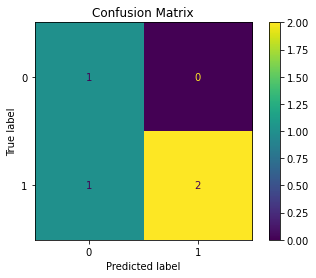

thresholds = array([2, 1, 0])


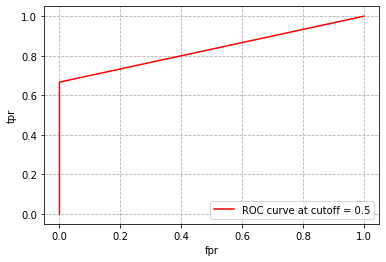

In [3]:
def evaluate(predictions, actual, mode, cutoff):
    
    confusion_matrix = metrics.ConfusionMatrixDisplay.from_predictions(actual, predictions)
    accuracy = metrics.accuracy_score(actual, predictions)
    precision = metrics.precision_score(actual, predictions, average="macro")
    recall = metrics.recall_score(actual, predictions, average="macro")
    # if multiclass:
    #     f1 = metrics.f1_score(actual, predictions, average="macro")
    #     roc_auc = roc_auc_score(actual, predictions, average="macro", multi_class="ovo")
    # else:
    f1 = metrics.f1_score(actual, predictions, average="macro")
    try:
        roc_auc = metrics.roc_auc_score(actual, predictions, average="macro", multi_class="ovo")
    except:
        roc_auc = None
    # roc_curve = metrics.roc_curve(actual, predictions)
    fpr, tpr, thresholds = None, None, None
    try:
        fpr, tpr, thresholds = roc_curve(actual, predictions)
    except:
        pass

    print(
        f"""
            mode: {mode}
            cutoff: {cutoff}
            accuracy: {accuracy}
            precision: {precision}
            recall: {recall}
            roc auc: {roc_auc}
            f1: {f1}
            fpr: {fpr}
            tpr: {tpr}
        """
    )
    plt.title("Confusion Matrix")
    plt.show()

    if fpr is not None:
        print(f"{thresholds = }")
        plt.plot(fpr, tpr, color="red", label=f"ROC curve at cutoff = {cutoff}")
        plt.grid(linestyle="--")
        plt.xlabel("fpr")
        plt.ylabel("tpr")
        plt.legend(loc="lower right")
        plt.show()

# test
evaluate([1, 0, 1, 0], [1, 1, 1, 0], "count", 0.5)


### 1.3 Function to Run Tests with a Given Model, Data, and KFolds.

In [4]:
def test(kf: KFold, text, labels, model=None):
    global cutoff
    cutoff_values = list(range(1, 5))
    for i in range(len(cutoff_values)):
        all_labels = []
        all_predictions = []
        cutoff = cutoff_values[i]

        # accumulate the predictions over the kfolds.
        for train_index, test_index in kf.split(text, labels):
            train_text = text[train_index]
            test_text = text[test_index]
            train_labels = PredictionModel.flip(labels[train_index], cutoff)
            test_labels = PredictionModel.flip(labels[test_index], cutoff)
            predictionmodel = PredictionModel(train_text, train_labels, mode="tfidf", model=model)
            predictions = predictionmodel.predict(test_text)
            all_labels.extend(test_labels)
            all_predictions.extend(predictions)
        
        # evaluate the performance.
        evaluate(predictions, test_labels, mode="tfidf", cutoff=cutoff)
        
def test_kaggle(train_text, train_labels, test_text):
    # global cutoff
    for cutoff_value in range(1, 5):
        t_labels = PredictionModel.flip(train_labels, cutoff=cutoff_value)
        model = PredictionModel(train_text, t_labels, mode="tfidf", model="logistic regression")
        predictions = model.predict(test_text)
        with open(f"predictions_{cutoff_value}.csv", "w") as f:
            f.write("id,predicted\n")
            for i, prediction in enumerate(predictions):
                f.write(f"{i},{prediction}\n")
            f.close()
    

In [5]:
# raw_kaggle_train_data = pd.read_csv("Training.csv")
# raw_kaggle_test_data = pd.read_csv("Test.csv")
# kg_train_text = raw_kaggle_train_data["reviewText"]
# kg_train_labels = raw_kaggle_train_data["overall"]
# kg_test_text = raw_kaggle_test_data["reviewText"]
# test_kaggle(kg_train_text, kg_train_labels, kg_test_text)

### 1.4 Load Data

In [6]:
cutoff = None
df = pd.read_csv("Training.csv")
text = df["reviewText"]
labels = df["overall"]
kf = KFold(n_splits=5, shuffle=True)


### 1.5 Test Logistic Regression


            mode: tfidf
            cutoff: 1
            accuracy: 0.8386157272571526
            precision: 0.7606861462885579
            recall: 0.6662344134578222
            roc auc: 0.6662344134578222
            f1: 0.6936853132173957
            fpr: [0.         0.61904762 1.        ]
            tpr: [0.         0.95151645 1.        ]
        


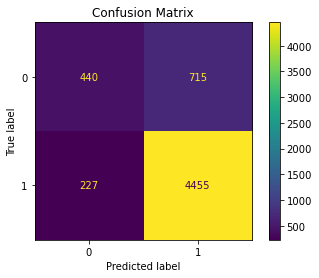

thresholds = array([2, 1, 0])


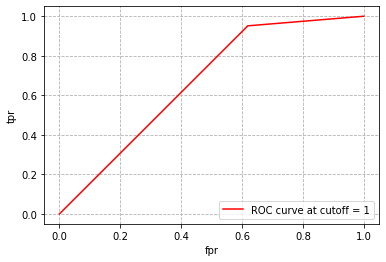


            mode: tfidf
            cutoff: 2
            accuracy: 0.7937296556450232
            precision: 0.7917100052604964
            recall: 0.7776411720492677
            roc auc: 0.7776411720492677
            f1: 0.7823441177410647
            fpr: [0.         0.31291667 1.        ]
            tpr: [0.         0.86819901 1.        ]
        


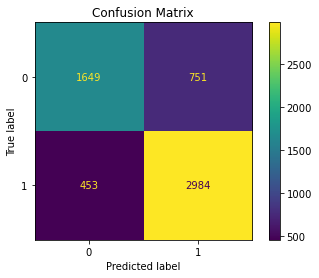

thresholds = array([2, 1, 0])


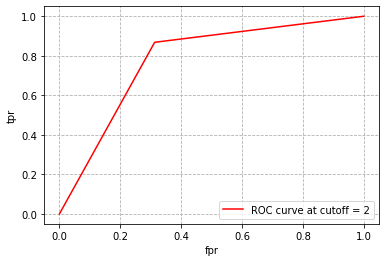


            mode: tfidf
            cutoff: 3
            accuracy: 0.8098338187425047
            precision: 0.8063144843466324
            recall: 0.7916829385546542
            roc auc: 0.7916829385546542
            f1: 0.7970492361565833
            fpr: [0.         0.11995452 1.        ]
            tpr: [0.        0.7033204 1.       ]
        


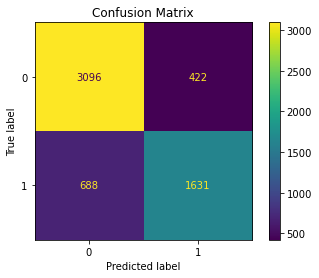

thresholds = array([2, 1, 0])


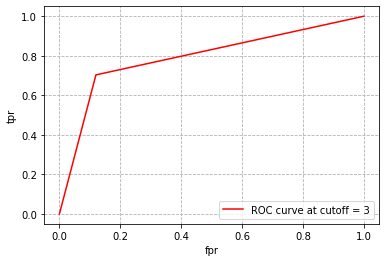


            mode: tfidf
            cutoff: 4
            accuracy: 0.8631146136714065
            precision: 0.8035983932210347
            recall: 0.7052336872518806
            roc auc: 0.7052336872518806
            f1: 0.7374764883444389
            fpr: [0.         0.03998308 1.        ]
            tpr: [0.         0.45045045 1.        ]
        


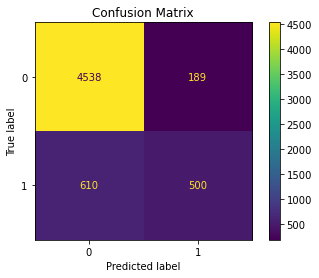

thresholds = array([2, 1, 0])


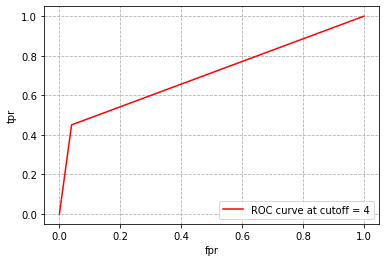

In [7]:
# test
test(kf, text, labels, model="logistic regression")

### 1.6 Test Naive Bayes



            mode: tfidf
            cutoff: 1
            accuracy: 0.7964707897892753
            precision: 0.8115997048704948
            recall: 0.5254712958540833
            roc auc: 0.5254712958540833
            f1: 0.49330057030353053
            fpr: [0.         0.94601128 1.        ]
            tpr: [0.         0.99695387 1.        ]
        


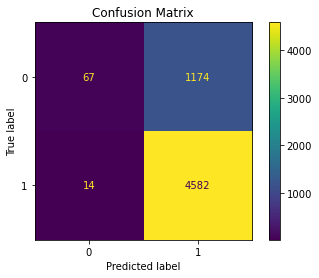

thresholds = array([2, 1, 0])


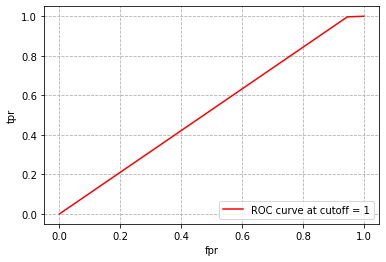


            mode: tfidf
            cutoff: 2
            accuracy: 0.7543258523213979
            precision: 0.779718814832719
            recall: 0.7184278637399313
            roc auc: 0.7184278637399312
            f1: 0.7238527275779285
            fpr: [0.         0.49006623 1.        ]
            tpr: [0.         0.92692195 1.        ]
        


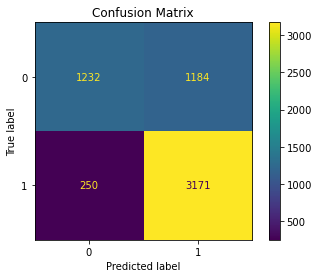

thresholds = array([2, 1, 0])


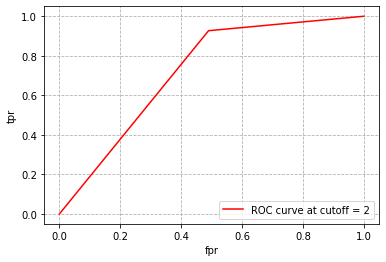


            mode: tfidf
            cutoff: 3
            accuracy: 0.769402090114785
            precision: 0.7998296477037663
            recall: 0.7194718311596671
            roc auc: 0.719471831159667
            f1: 0.7292000487512861
            fpr: [0.         0.05337079 1.        ]
            tpr: [0.         0.49231445 1.        ]
        


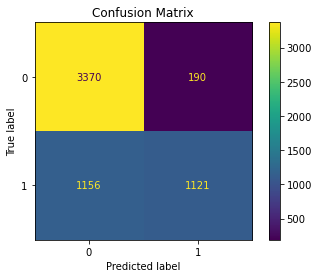

thresholds = array([2, 1, 0])


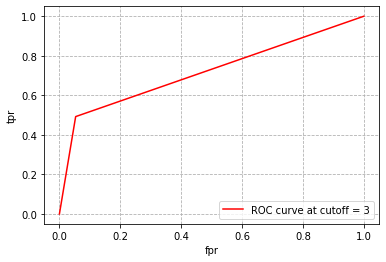


            mode: tfidf
            cutoff: 4
            accuracy: 0.8115470275826623
            precision: 0.7674424207381709
            recall: 0.5208427993676377
            roc auc: 0.5208427993676377
            f1: 0.49065832770104106
            fpr: [0.        0.0042508 1.       ]
            tpr: [0.        0.0459364 1.       ]
        


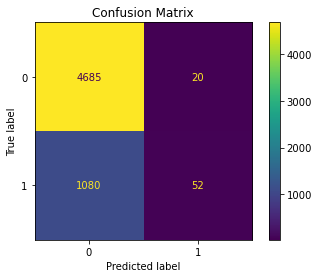

thresholds = array([2, 1, 0])


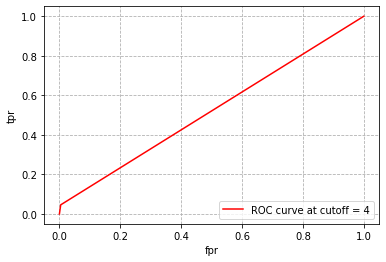

In [8]:
test(kf, text, labels, model="naive bayes")

### 1.7 Test Support Vector Machines

/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: Convergen


            mode: tfidf
            cutoff: 1
            accuracy: 0.728456398835018
            precision: 0.5726811395186258
            recall: 0.5605377225866917
            roc auc: 0.5605377225866917
            f1: 0.5641262003891261
            fpr: [0.         0.73513085 1.        ]
            tpr: [0.         0.85620629 1.        ]
        


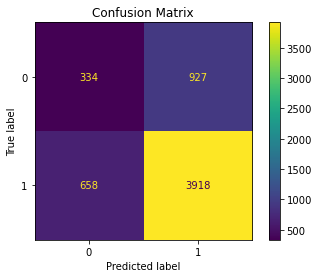

thresholds = array([2, 1, 0])


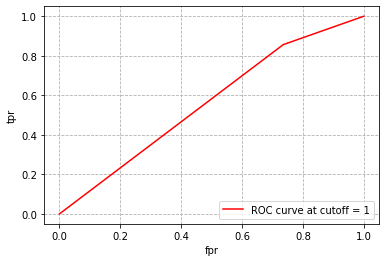

/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: Convergen


            mode: tfidf
            cutoff: 2
            accuracy: 0.627205756381703
            precision: 0.6097819467492128
            recall: 0.6000658718413937
            roc auc: 0.6000658718413937
            f1: 0.6002777499434782
            fpr: [0.         0.55328893 1.        ]
            tpr: [0.         0.75342067 1.        ]
        


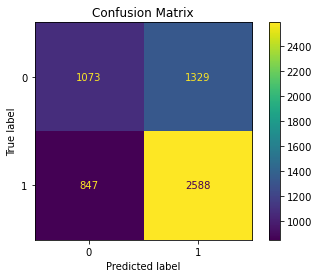

thresholds = array([2, 1, 0])


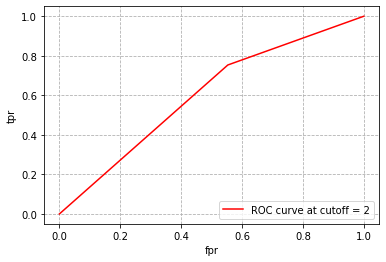

/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: Convergen


            mode: tfidf
            cutoff: 3
            accuracy: 0.5965393181428816
            precision: 0.6025466217036907
            recall: 0.6080456570155901
            roc auc: 0.6080456570155902
            f1: 0.5932107463396799
            fpr: [0.         0.44181514 1.        ]
            tpr: [0.         0.65790646 1.        ]
        


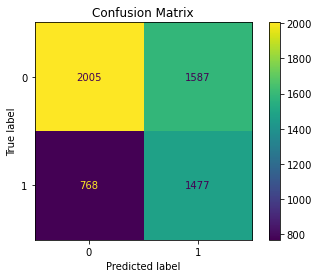

thresholds = array([2, 1, 0])


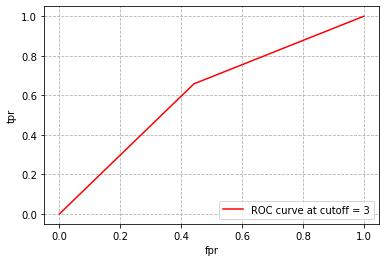

/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: Convergen


            mode: tfidf
            cutoff: 4
            accuracy: 0.49032037005310947
            precision: 0.5501512635788873
            recall: 0.5771019838452112
            roc auc: 0.5771019838452113
            f1: 0.46671693908822043
            fpr: [0.         0.56498617 1.        ]
            tpr: [0.         0.71919014 1.        ]
        


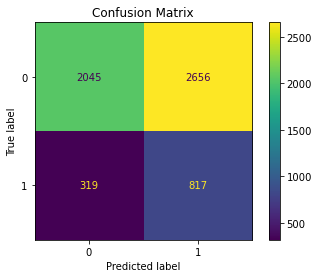

thresholds = array([2, 1, 0])


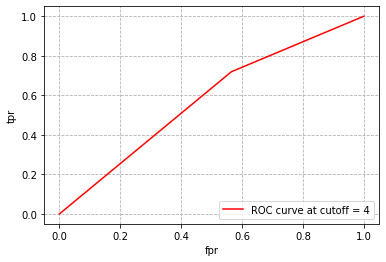

In [9]:
test(kf, text, labels, model="svm")

## 1.8 REPORT ON BINARY CLASSIFICATION

- First, I tested `CountVectorizer` and `TfidfVectorizer` for feature extraction from the text and found their accuracy relatively similar, but `CountVectorizer` was generally taking more time to train and predict. I therefore settled on `TfidfVectorizer` as the feature extraction method.
- Interestingly, using stopwords seemed to hurt the performance of the models.
- Of the three models I tested:
  - `LogisticRegression` was the most accurate across the different cutoffs, maintaining an $F1$ score of $0.70, 0.77, 0.80, 0.72$ across cutoffs $1, 2, 3, 4$.
  - `MultiNomialNB` was the most accurate across the different cutoffs, maintaining an $F1$ score of $0.50, 0.73, 0.71, 049$ across cutoffs $1, 2, 3, 4$. It is notable that the model's performance diminishes when the classes become more skewed (e.g. cutoff 1 and cutoff 4) and better when the split is more even.
  - `SVC` (Support Vector Machines) was generally the worst-performing, maintaining an $F1$ score between $0.50$ and $0.60$ for all cutoffs. Changing the cutoffs didn't seem to change the performance that much.
- The best performing model was `LogisticRegression` with a cutoff of $1$.
- For the best model, I found logistic regression with L1 loss to perform best. I tested several other hyperparameters, including fixing vs. fitting the intercept and using intercept scaling, but I didn't see any significant improvements with any of those hyperparameters.


## 2. Multiclass Classification.

- For this section, I reused the general classifier I built for part 1, sans the cutoff mapping of values to either $0$ or $1$.


In [10]:
def test_multiclass(kf: KFold, text, labels, model=None):
    all_labels = []
    all_predictions = []

    # accumulate the predictions over the kfolds.
    for train_index, test_index in kf.split(text, labels):
        train_text = text[train_index]
        test_text = text[test_index]
        train_labels = np.array(labels[train_index])
        test_labels = np.array(labels[test_index])
        predictionmodel = PredictionModel(train_text, train_labels, mode="tfidf", model=model)
        predictions = predictionmodel.predict(test_text)
        all_labels.extend(test_labels)
        all_predictions.extend(predictions)
    
    # evaluate the performance.
    evaluate(predictions, test_labels, mode="tfidf", cutoff=cutoff)
    

### 2.1 Multiclass Logistic Regression


            mode: tfidf
            cutoff: 4
            accuracy: 0.47130375192735996
            precision: 0.4637605878224207
            recall: 0.469884178507761
            roc auc: None
            f1: 0.46593561648823983
            fpr: None
            tpr: None
        


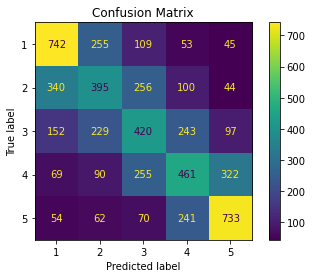

In [11]:

test_multiclass(kf, text, labels, model="logistic regression")

### 2.2 Multiclass Naive Bayes


            mode: tfidf
            cutoff: 4
            accuracy: 0.4509165667294843
            precision: 0.4527501854144691
            recall: 0.45085265106551614
            roc auc: None
            f1: 0.4512568666201561
            fpr: None
            tpr: None
        


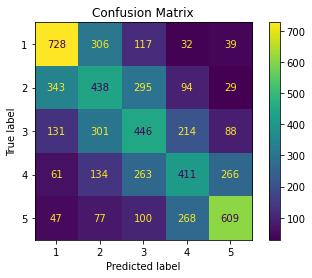

In [12]:
test_multiclass(kf, text, labels, model="naive bayes")

### 2.3 Multiclass Support Vector Machines

/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:284: Convergen


            mode: tfidf
            cutoff: 4
            accuracy: 0.31591571012506425
            precision: 0.32105200065509004
            recall: 0.31475099582926624
            roc auc: None
            f1: 0.31077779457540144
            fpr: None
            tpr: None
        


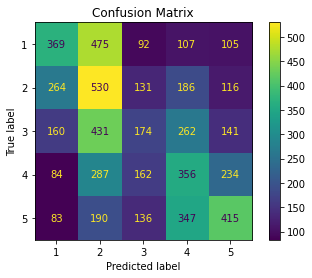

In [13]:
test_multiclass(kf, text, labels, model="svm")

### 2.4 REPORT ON MULTICLASS CLASSIFICATION

- As we can see from the results above, Logistic Regression once again has the bet performance on the multiclass classification task at an F1 score of $0.47$, albeit closely seconded by Multinomial Naive Bayes at $0.45$. Support Vector Machines has the worst performance, with an F1 score of $0.26$.
- I mostly used the same hyper-parameters for this task as for the binary classification task.

In [14]:
# Generate a CSV of Predictions for Kaggle Submission

raw_kaggle_train_data = pd.read_csv("Training.csv")
raw_kaggle_test_data = pd.read_csv("Test.csv")
kg_train_text = raw_kaggle_train_data["reviewText"]
kg_train_labels = raw_kaggle_train_data["overall"]
kg_test_text = raw_kaggle_test_data["reviewText"]

model = PredictionModel(kg_train_text, kg_train_labels, mode="tfidf", model="logistic regression")
predictions = model.predict(kg_test_text)

with open(f"predictions_multiclass.csv", "w") as f:
    f.write("id,predicted\n")
    for i, prediction in enumerate(predictions):
        f.write(f"{i},{prediction}\n")
    f.close()
    

## 3 Clustering

### 3.1 K-Means Clustering Code

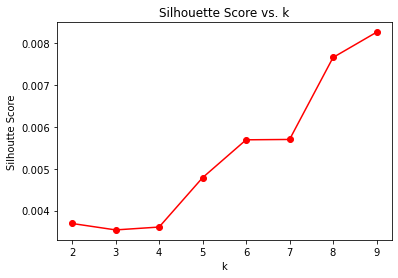

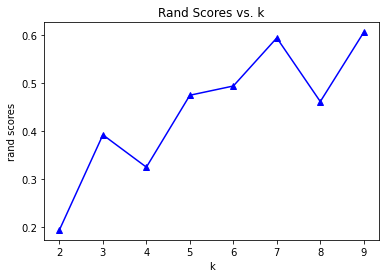

actual_labels = ['CDs' 'automotive' 'cell_phones' 'grocery' 'sports' 'toys']
best_k = 9, real_k = 6
silhouette score for best cluster: 0.008893865477450672
rand score for best cluster: 1.0
                                                  title  cluster
3816  these were much smaller than i expected. when ...        0
1863  it's pretty good. it's pretty thin compared to...        0
2945  this was the surprise of the year, honestly! i...        0
642   used it as the directions implied i noticed a ...        0
431   works good wish it came with more adapters and...        0
...                                                 ...      ...
1831                                         just ok...        8
3185                            ok zipper is very cheap        8
339         sound ok not loud enough like some pple say        8
686                                        i like it ok        8
388   it's ok. nothing extra from what  i have  used...        8

[4500 rows x 2 columns]
      

In [15]:
from sklearn.metrics import silhouette_score, rand_score
from sklearn.cluster import KMeans

def cluster_text(text, labels):
    vectorizer = TfidfVectorizer(stop_words="english")
    X = vectorizer.fit_transform(text)

    silhouette_scores = []
    rand_scores = []
    K = list(range(2, 10))
    for k in K:
        km = KMeans(n_clusters=k, max_iter=200, n_init=10)
        km = km.fit(X)
        silhouette_scores.append(silhouette_score(X, km.labels_, metric='euclidean'))
        rand_scores.append(rand_score(labels, km.labels_))
    plt.xlabel("k")
    plt.ylabel("Silhoutte Score")
    plt.plot(K, silhouette_scores, "ro-")
    plt.title("Silhouette Score vs. k")
    plt.show()
    plt.xlabel("k")
    plt.ylabel("rand scores")
    plt.title("Rand Scores vs. k")
    plt.plot(K, rand_scores, "b^-")
    plt.show()

    print(f"actual_labels = {np.unique(labels)}") 
    best_k = K[np.argmax(silhouette_scores)]
    real_k = len(np.unique(labels))
    print(f"{best_k = }, {real_k = }")

    km = KMeans(n_clusters=best_k, init="k-means++", max_iter=10000, n_init=100, random_state=10)
    km.fit(X)

    labels=km.labels_
    clusters=pd.DataFrame(list(zip(text,labels)),columns=["title","cluster"])
    print(f"silhouette score for best cluster: {silhouette_score(X, km.labels_, metric='euclidean')}")
    print(f"rand score for best cluster: {rand_score(labels, km.labels_)}")
    print(clusters.sort_values(by=["cluster"]))

    for i in range(best_k):
        print(clusters[clusters["cluster"] == i])
        
df = pd.read_csv("Test.csv")
text = df["reviewText"]
labels = df["category"]
cluster_text(text, labels)



### 3.2 Clustering Report

- The silhouette score seems to increase as we increase the number of clusters, althouth after some points the changes become negligible. Looking at the silhouette scores, I had $9$ as the best $k$.
- On other hand, the rand score suggests that the best $k$ is either $7$ or $9$. I went with $9$ (since it had a higher score). If we look at the actual data, we have $6$ actual clusters so $9$ is not the worst estimate.